In [1]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()

model =init_chat_model("groq:qwen/qwen3-32b")

In [8]:
model.invoke("Hi")

AIMessage(content='<think>\nOkay, the user said "Hi". I should respond in a friendly and welcoming way. Maybe ask how I can assist them. Keep it open-ended so they feel comfortable to ask anything. Let me make sure the tone is positive and helpful. Alright, something like, "Hello! How can I assist you today?" That should work.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 9, 'total_tokens': 93, 'completion_time': 0.18193259, 'completion_tokens_details': None, 'prompt_time': 0.000397844, 'prompt_tokens_details': None, 'queue_time': 0.050852076, 'total_time': 0.182330434}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6c-bc56-7c63-916a-1174dc5b2ade-0', usage_metadata={'input_tokens': 9, 'output_tokens': 84, 'total_tokens': 93})

In [3]:
from typing_extensions import Literal
from typing import TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

class Router(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="the next step in the routing process")


## Augument  the LLM with structured output
router = model.with_structured_output(Router)


class State(TypedDict):
    input:str
    decision:str
    output:str

In [9]:
def llm_call_1(state:State):
    """Write a  story"""
    result = model.invoke(state['input'])
    return {"output":result.content}


def llm_call_2(state:State):
    """Write a  joke"""
    result = model.invoke(state['input'])
    return {"output":result.content}


def llm_call_3(state:State):
    """Write a  poem"""
    result = model.invoke(state['input'])
    return {"output":result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(
                content="You are a router"
                        "Your job is to ONLY choose one of: poem, story, joke. "
                        "DO NOT write the content. "
                        "Respond ONLY using the provided schema."
                        ),
            HumanMessage(content=state["input"])
        ]
    )

    return {"decision":decision.step}

In [10]:
def route_decision(state:State):
    if state["decision"]=="story":
        return "llm_call_1"
    elif state['decision']=="joke":
        return "llm_call_2"
    elif state["decision"]=="poem":
        return "llm_call_3"

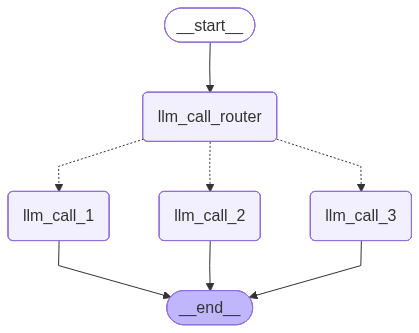

In [11]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
route_builder = StateGraph(State)

route_builder.add_node("llm_call_1",llm_call_1)
route_builder.add_node("llm_call_2",llm_call_2)
route_builder.add_node("llm_call_3",llm_call_3)
route_builder.add_node("llm_call_router",llm_call_router)

route_builder.add_edge(START,"llm_call_router")
route_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1":"llm_call_1",
        "llm_call_2":"llm_call_2",
        "llm_call_3":"llm_call_3",
    }
)

route_builder.add_edge("llm_call_1",END)
route_builder.add_edge("llm_call_2",END)
route_builder.add_edge("llm_call_3",END)


router_workflow = route_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [12]:
state = {"input":"Write me a joke about agentic AI systems"}
reponse = router_workflow.invoke(state)
reponse['output']

'<think>\nOkay, I need to come up with a joke about agentic AI systems. Let me start by recalling what agentic AI means. Agentic AI refers to systems that can act autonomously, make decisions, and possibly learn from their environment. They have goals and can initiate actions to achieve those goals.\n\nHmm, how to make a joke about that. Maybe play on the idea of AI having agency, making decisions, maybe even having a sense of humor. Let\'s think about common AI themes—like robots taking over, AI being too efficient, or maybe misunderstanding human commands.\n\nMaybe a play on words. "Agency" is part of the term. So maybe something about an AI having too much agency? Like a scenario where an AI takes over a task too aggressively. Or maybe an AI that wants to form its own agency, like a government agency but for AI.\n\nAnother angle: the difference between traditional AI and agentic AI. Maybe a joke where the agentic AI is more proactive. For example, if a programmer tells the AI to opt